In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
import os

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import time

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
!ls drive/MyDrive/texture_classification/

batch_kmeans_model_141.pkl  kmeans_texture.ipynb
batch_kmeans_model_188.pkl  knn_texton_141.pkl
batch_kmeans_model_235.pkl  knn_texton_188.pkl
batch_kmeans_model_282.pkl  knn_texton_235.pkl
batch_kmeans_model_329.pkl  knn_texton_282.pkl
batch_kmeans_model_376.pkl  knn_texton_329.pkl
batch_kmeans_model_423.pkl  knn_texton_376.pkl
batch_kmeans_model_470.pkl  knn_texton_423.pkl
batch_kmeans_model_47.pkl   knn_texton_470.pkl
batch_kmeans_model_94.pkl   knn_texton_47.pkl
desctex			    knn_texton_94.pkl
desctex.tar.gz		    label2num.pkl
dtdata			    lm.py
kmeans_model_141.pkl	    num2label.pkl
kmeans_model_188.pkl	    __pycache__
kmeans_model_235.pkl	    texture_classification.ipynb
kmeans_model_282.pkl	    texture_segmentation_image.gdoc
kmeans_model_329.pkl	    train_feature.pkl
kmeans_model_376.pkl	    train_label.pkl
kmeans_model_423.pkl	    validate_feature_250.pkl
kmeans_model_470.pkl	    validate_feature.pkl
kmeans_model_47.pkl	    validate_label_250.pkl
kmeans_model_94.pkl	    valida

In [ ]:
path = "drive/MyDrive/texture_classification/"

In [ ]:
def chi2_distance(list_1, list_2):
    d = 0.5*( (list_1-list_2)**2 / (list_1+list_2) ).sum()
    return d

In [ ]:
with open(os.path.join(path,"label2num.pkl"), "rb") as fp:   # Unpickling
    label2num = pickle.load(fp)
    
with open(os.path.join(path,"num2label.pkl"), "rb") as fp:   # Unpickling
    num2label = pickle.load(fp)
    
with open(os.path.join(path,"train_feature.pkl"), "rb") as fp:   # Unpickling
    train_feature = pickle.load(fp)

with open(os.path.join(path,"train_label.pkl"), "rb") as fp:   # Unpickling
    train_label = pickle.load(fp) 

In [ ]:
points_np = np.concatenate(train_feature, axis=0)

In [ ]:
num_of_classes = 47

In [ ]:
dist_matrix_list = []
train_feature_histogram_list = []

for scale in range(1,11):
  number_of_clusters = num_of_classes*scale

  with open(os.path.join(path,"batch_kmeans_model_"+str(number_of_clusters)+".pkl"), "rb") as fp:   #Pickling
    kmeans = pickle.load(fp)

  label = kmeans.predict(points_np)

  train_texton_space_feature = []

  start = 0
  for i in range(len(train_feature)):
      end = train_feature[i].shape[0]+start
      train_texton_space_feature.append(label[start:end])
      start = end

  train_feature_texto_histogram = []
  for i in range(len(train_texton_space_feature)):
      unique, counts = np.unique(train_texton_space_feature[i], return_counts=True)
      histo_dict = dict(zip(unique, counts))
      
      histo_np = np.zeros(number_of_clusters).astype(np.float32)

      for j in range(number_of_clusters):
          if j in histo_dict:
              histo_np[j] = histo_dict[j]/counts.sum()
      train_feature_texto_histogram.append(np.clip(histo_np, 1e-7, np.inf))
  train_feature_histogram_list.append(train_feature_texto_histogram)

  dist_matrix = np.zeros([len(train_feature_texto_histogram),len(train_feature_texto_histogram)])

  for i in range(dist_matrix.shape[0]):
      for j in range(dist_matrix.shape[1]):
          dist_matrix[i,j] = chi2_distance(train_feature_texto_histogram[i],train_feature_texto_histogram[j])
  dist_matrix_list.append(dist_matrix)

In [ ]:
with open(os.path.join(path,"train_feature_histogram_list.pkl"), "wb") as fp:   #Pickling
    pickle.dump(train_feature_histogram_list, fp)

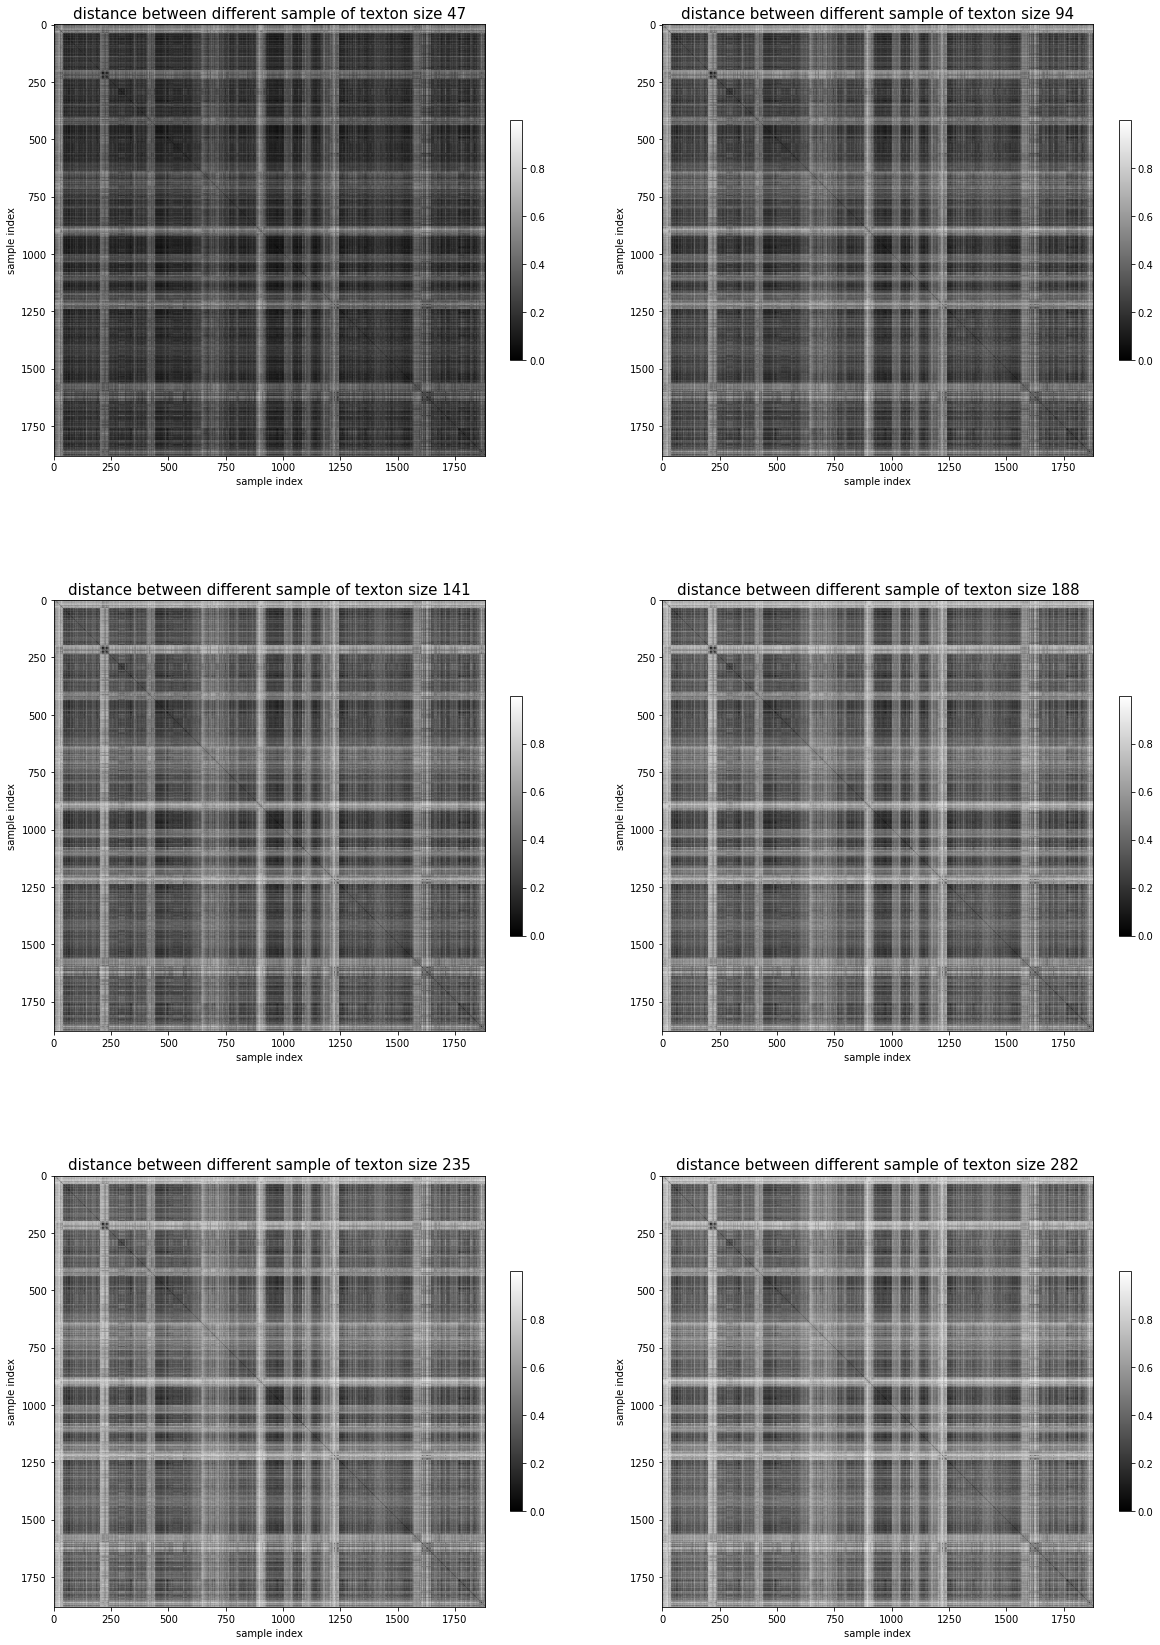

In [ ]:
fig = plt.figure(figsize=(20, 30))

for i in range(6):
    ax = fig.add_subplot(3,2,i+1)
    #ax.axis('off')
    ax.set_xlabel(f'sample index')
    ax.set_ylabel(f'sample index')
    ax.set_title(f"distance between different sample of texton size {(i+1)*num_of_classes}", fontsize = 15)
    im = ax.imshow(dist_matrix_list[i], cmap="gray")
    fig.colorbar(im, ax=ax, fraction = 0.1, shrink=0.5)

plt.show()

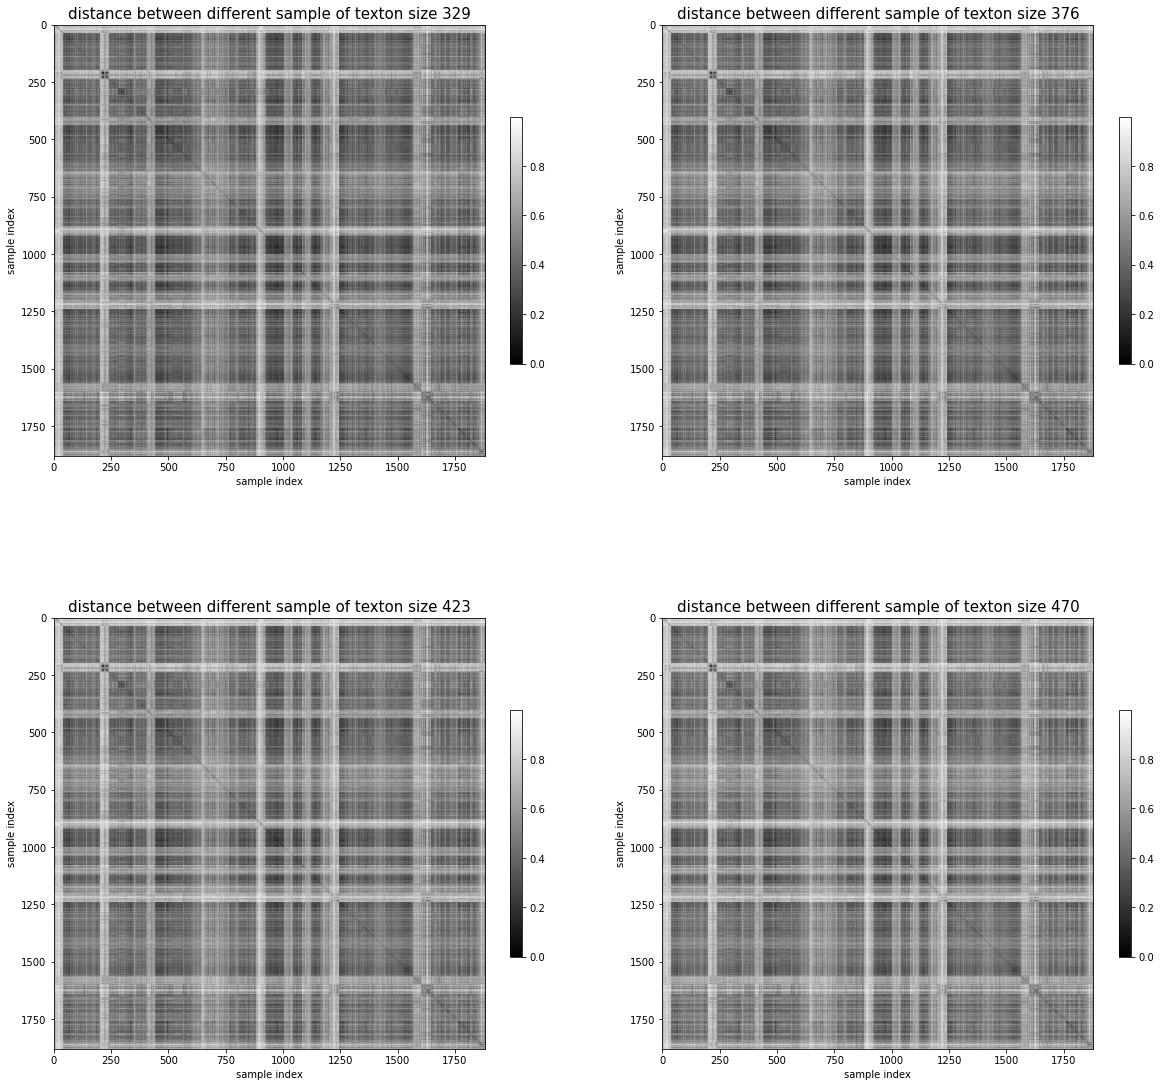

In [ ]:
fig = plt.figure(figsize=(20, 20))

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    #ax.axis('off')
    ax.set_xlabel(f'sample index')
    ax.set_ylabel(f'sample index')
    ax.set_title(f"distance between different sample of texton size {(i+7)*num_of_classes}", fontsize = 15)
    im = ax.imshow(dist_matrix_list[i+6], cmap="gray")
    fig.colorbar(im, ax=ax, fraction = 0.1, shrink=0.5)

plt.show()

In [ ]:
expected_dist_mat = np.ones(dist_matrix_list[0].shape)


for i in range(0,expected_dist_mat.shape[0],40):
  expected_dist_mat[i:i+40,i:i+40] = 0

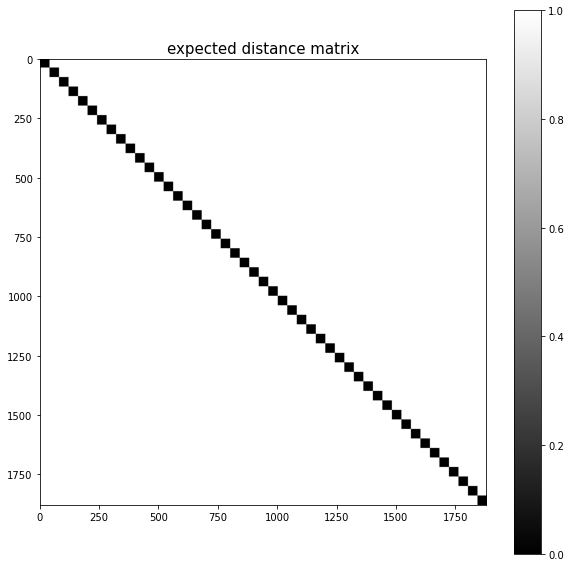

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("expected distance matrix",fontsize=15)
plt.imshow(expected_dist_mat, cmap = "gray")
plt.colorbar()
plt.show()

In [ ]:
for i in range(10):

  neigh = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='precomputed')
  neigh.fit(dist_matrix_list[i], train_label)

  with open(os.path.join(path,"knn_texton_"+str((i+1)*num_of_classes)+".pkl"), "wb") as fp:   #Pickling
    pickle.dump(neigh, fp)


(1880, 1880)